In [1]:
from accelerator import *
import numpy as np
import matplotlib.pyplot as plt

def plot_beta(beta_h, beta_v, s):
    """Plot the beta functions.
    """
    fig, axes = plt.subplots(1, 1)
    axes.plot(s, beta_h, label='beta h')
    axes.plot(s, beta_v, label='beta v')
    axes.legend()
    plt.xlabel('s [m]')
    plt.ylabel('beta [m]')
    return fig, axes

# Hands on tutorial 2
# Introduction
The goal of this tutorial is to continue the design of the accelerator we started in the previous tutorial. We will further optimize our ring and we will introduce the idea of chromatic compensation as well as the concept of extraction bump.
## What do we have so far
We started designing an accelerator ring for protons at a momentum of 15 GeV/c with the followin basic parameters:
 * Circumference = 1000 m
 * Quadrupole length = 3.0 m
 * Dipole length = 5 m
 * Maximum magnetic fiel in dipoles = 2 T
 * 8 FODO cells

The first thing we did was to close the ring with dipoles. We decided to place 32 dipoles (we actually needed 31.4 dipoles). This also gives a good periodicity of the FODO cells such that we have a regular and symmetric structure. Then we found the right value of the strength of the quadrupoles in order to achieve a maximum $\beta$-function of 300 m ($k_q l = 8.89\times 10^{-3} m^{-1}$, i.e. $f = 112.5$ m). But this accelerator was very poorly designed and we wanted to further optimize the $\beta$-function by lowering it to the minimum value possible with the present configuration. We managed to achieve a maximum $\beta$-function of around 208 m. But this value would still result in a beam size which is too large. Therefore, in order to reduce the **maximum $\beta$-function below 100 m***, we decided to change the configuration of our ring by increasing the number of FODO cells. The **minimum number of FODO cells to achieve $\beta_\text{max} = 100$ m is 17, but we would like to have more symmetry and we decide to go to with 20 FODO cells.** In summary, the lattice we have now contains:

 * 20 FODO cells (this is not the only possibility, but let us choose this one for the sake of symmetry)
 * 80 dipoles (4 per FODO cell)
 * 40 quadrupoles (20 focusing, 20 defocusing)


Note that, with the initial constraint in the dipole field ($B_\text{max} = 2$ T) we could use only 2 dipoles per cell instead of 4.

**What would be the advantages of keeping 4 dipoles per cell instead of 2? Are there some disadvantages, too?**

In this situation, the angle given by each dipole is simply $2\pi /80$ and the normalized quadrupole gradient ($k_q$) is in the order of $1.0 \times 10^{-2}~\text{m}^{-2}$.

## What is still to be done?

We follow the usual steps for the design of a new machine: after having defined the main lattice with dipoles and quadrupoles, we now want to optimize the linear optics of the machine. In our case that means exploiting our FODO cells to their maximum, reducing the maxima of the beta function in both planes in order to reduce the maximum beam size. The problems induced by "off-momentum particles" were introduced in the lectures, and in the second part of this tutorial we will have a look at these kinds of issues. Finally, we will implement something that you also saw in the lectures: the concept of orbit bumps.

Note that in this and next tutorials we will **only use thick lenses** in our sequences.

In [2]:
circumference = 1000
n_cells = 20
cell_length = circumference / n_cells

dipole_length = 5
dipole_angle = 2 * np.pi / (n_cells * 4)
dipole_bending_radius = dipole_length / dipole_angle

quadrupole_length = 3
quadrupole_strength = 1e-2

drift_length = (circumference / n_cells - (2 * quadrupole_length) - (4 * dipole_length)) / 6

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='x [m]', ylabel='z [m]'>)

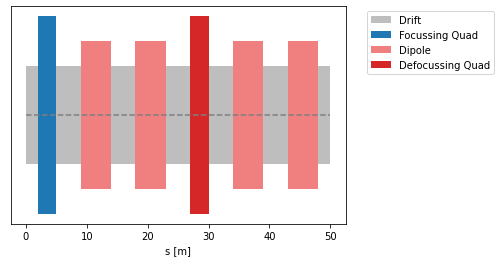

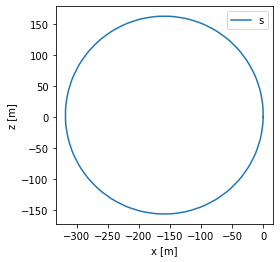

In [3]:
dipole = Dipole(dipole_bending_radius, dipole_angle)
quad_f = Quadrupole(quadrupole_strength, quadrupole_length, name='quad_f')
quad_d = Quadrupole(-quadrupole_strength, quadrupole_length, name='quad_d')
drift = Drift(drift_length)
drift_half = Drift(drift_length / 2)

FODO = Lattice([drift_half,
                quad_f,
                drift, dipole,
                drift, dipole,
                drift,
                quad_d,
                drift, dipole,
                drift, dipole,
                drift_half])
FODO.plot.layout()
lattice = FODO * n_cells
lattice.plot.top_down()

# Problem: Design an accelerator -- Part II
## Step 1: (Re)Matching the FODO cell

As you have seen so far, achieving precise design values for the optical parameters can be tedious. Nevertheless we can use the ~python package~ to match these parameter to a certain design value. Once the lattice is properly defined, and if the values we want to achieve are compatible with the lattice, it is possible to use the constraint matching of the ~python package~. These commands do not contain any physics, they are just optimized iterations, allowing to match a certain number of constraints by playing with free parameters. Since the "matching" commands do not know the physics of the problem, the free parameters have to be carefully chosen so that they actually act on the constrained parameters. For instance trying to match the tunes with octupoles will most probably not work: the algorithm will never converge and the matching will fail.

Our goal will be to **match the maximum of both the beta functions to 100 m** (yes... again!), but this time python will do the work for you. For the matching command you have to specify:
 * what variables have to be varied (free parameters)
 * the target paramters, along with their value and location

**Determine how many variables we have to vary, which are these variables, in which position of the lattice we have to specify the constraints, and what are these constraints?**

Take inspiration from the example block bellow.

In `lattice.constraints.add_free_parameter(???, ???)` you have to put the element and its attribute you want to vary. In `lattice.constraints.add_target(???, [100, None, None], twiss="solution", plane='h')` you have to put the element at which the constraint should be applied.

**Which are the final values of the variables that you obtained after the matching?**

In [4]:
lattice.constraints.clear()
lattice.constraints.add_free_parameter(quad_f, "k")  # ??
lattice.constraints.add_free_parameter(quad_d, "k")  # ??

lattice.constraints.add_target(TargetTwiss(quad_f, [100, None, None], plane='h'))  # ??
lattice.constraints.add_target(TargetTwiss(quad_d, [100, None, None], plane='v'))  # ??

lattice_matched, opt_result = lattice.constraints.match()
opt_result

[83.05924103979787, 7.47083765556498]
83.39454980622565
[100.10872882214963, 18.04599219503261]
101.72224643945822
[68.60994339171468, 39.75480339574761]
79.29545210949262
[44.002755665575314, 57.245325653005615]
72.20297649877728
[0.7650642465644475, 82.92142298118912]
82.92495229137398
[24.144636223813855, 78.64723640916603]
82.26998999136657
[41.66233130001663, 64.78279607605616]
77.02311676882611
[9.054550071835035, 79.45335304759617]
79.96761961887653
[56.51992561570096, 50.85105633235222]
76.0284941434488
[58.7884872834504, 42.04885060237085]
72.27857271734766
[46.43339983107219, 48.974366204483125]
67.48740004625331
[40.91595654589501, 48.075457003537984]
63.12974787027585
[23.08933183524879, 62.90938370113889]
67.01274358101863
[19.030223230109005, 54.35605051763435]
57.59105506989257
[3.827129911444819, 53.131655154804136]
53.26931295641141
[25.351959845036717, 35.91350981914271]
43.960232659916784
[27.15225021536135, 18.853179976698915]
33.0558177480363
[16.57818676936638, 26

 final_simplex: (array([[ 0.00713572, -0.00797439],
       [ 0.00713571, -0.00797438],
       [ 0.00713572, -0.00797439]]), array([0.00026264, 0.00031684, 0.00032152]))
           fun: 0.0002626442735285868
       message: 'Optimization terminated successfully.'
          nfev: 94
           nit: 49
        status: 0
       success: True
             x: array([ 0.00713572, -0.00797439])

In [5]:
twiss_h = lattice_matched.twiss(plane='h')
twiss_v = lattice_matched.twiss(plane='v')

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='s [m]', ylabel='beta [m]'>)

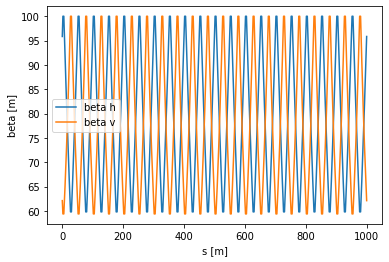

In [6]:
plot_beta(twiss_h.beta, twiss_v.beta, twiss_h.s)

# Step 2: Sextupoles and chromaticity

The machine we obtained now has a certain *natural chromaticity*.

**Recall the definition of chromaticity.**

The latest twiss file you obtained contains the values of the horizontal chromaticity ($dq1$) and vertical chromaticity ($dq2$).

**What are their values? Can you justify the sign of these values?**

For reasons out of the scope of this tutorial, it is usually advisable to reduce the chromaticity to a smaller absolute value, and in the case of a machine running "above transition" (see a future lecture on longitudinal dynamics) to have a small positive chromaticity. Therefore, it would be good to find a way to correct the chromaticity. To this end we use sextupoles, which are second-order non-linear magnets, located in places with non-zero dispersion. Since we are using thick lenses, there is no analytical way to calculate this chromaticity change and therefore we will use computational methods. However, it is interesting for you to know that in the thin lense approximation you can calculate the change in chromaticity analytically:

\begin{equation}
\Delta Q_x' = \frac{1}{4\pi} n_{cell} \left( k_2^f l_s D_x^f \beta_x^f + k_2^d l_s D_x^d \beta_x^d \right)
\end{equation}

\begin{equation}
\Delta Q_y' = \frac{1}{4\pi} n_{cell} \left( k_2^f l_s D_x^f \beta_y^f + k_2^d l_s D_x^d \beta_y^d \right)
\end{equation}

where $k_2^f$ (resp. $k_2^d$ ) is the strength of the sextupole located at the focusing (resp. defocusing) quadrupole, $D_x^f$ (resp. $D_x^d$) is the dispersion at the focusing (resp. defocusing) quadrupole, $\beta_x^f$ (resp. $\beta_x^d$ ) is the horizontal beta function at the focusing (resp. defocusing) quadrupole, the same for the vertical beta function.

**Why do we need sextupoles to correct the chromaticity? Why do we need to have non-zero dispersion?**

Let's add the sextupole to the lattice, next to the focussing/defocussing quadrupoles.

In [18]:
k = 1/0.8
l_quad = 0.1
L = 1.  # drift length (m). Note FODO total length: 2L

quad_F = Quadrupole(k, l_quad)
quad_D = Quadrupole(-k, l_quad)
drift = Drift(L)

FODO = Lattice([quad_F, drift, quad_D, drift])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='s [m]'>)

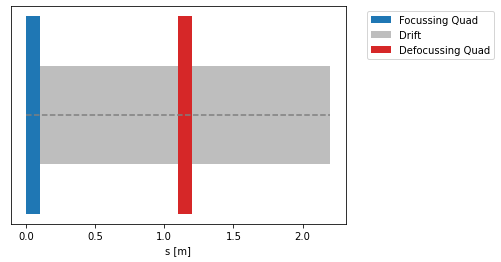

In [19]:
FODO.plot()

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='s [m]'>)

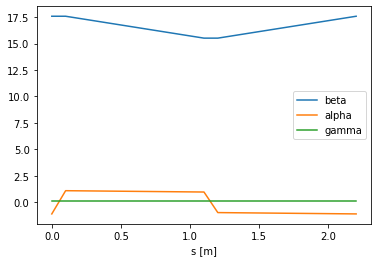

In [20]:
FODO.twiss().plot()

[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[-0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 

 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [

 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [

 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 

[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [ 0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [ 0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[ 0.]
 [-0.]
 [-0.]
 [-0.]
 [ 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [

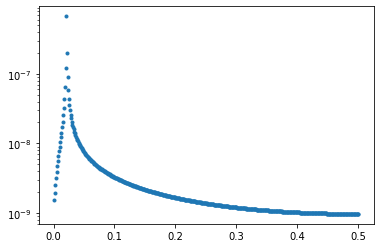

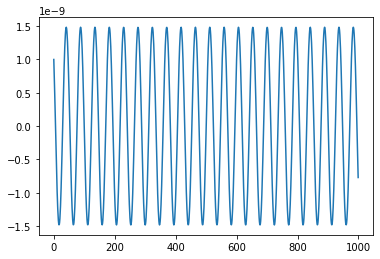

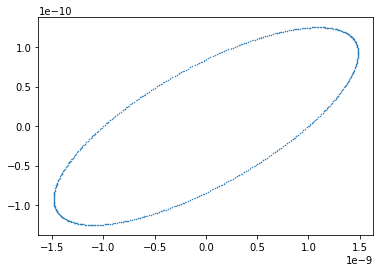

0.021

In [21]:
FODO.tune(n_turns=1000)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [

 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[

 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[

 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[

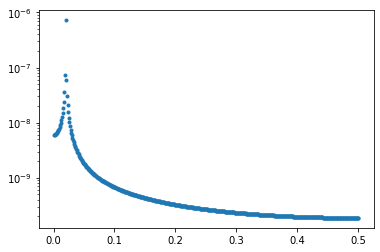

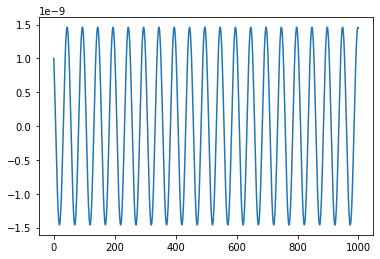

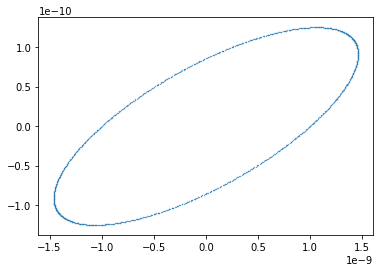

0.02

In [17]:
FODO.tune(dp=1e-6, n_turns=1000)

In [12]:
raise

RuntimeError: No active exception to reraise

In [ ]:
quad_f = Quadrupole(1, 1)
 = Quadrupole(-1, 1)
drift = Drift(2)
FODO_sext = Lattice([quad_f,
                     quad_f,
#                      sext_f,
                     Drift(drift_length - l_sext),
                     dipole, drift,
                     dipole, drift,
                     quad_d,
#                      sext_d,
                     Drift(drift_length - l_sext),
                     dipole, drift,
                     dipole,
                     drift_half,
                     ])
FODO_sext.plot()
FODO_sext.plot.top_down()
lattice_sext = FODO_sext * n_cells

In [ ]:
l_sext = 0.5
k_sext_f = 1e-3
k_sext_d = -1e-3
sext_f = Sextupole(k_sext_f, l_sext, name="sextupole_f")
sext_d = Sextupole(k_sext_d, l_sext, name="sextupole_d")
FODO_sext = Lattice([drift_half,
                     quad_f,
#                      sext_f,
                     Drift(drift_length - l_sext),
                     dipole, drift,
                     dipole, drift,
                     quad_d,
#                      sext_d,
                     Drift(drift_length - l_sext),
                     dipole, drift,
                     dipole,
                     drift_half,
                     ])
FODO_sext.plot()
FODO_sext.plot.top_down()
lattice_sext = FODO_sext * n_cells

**Verify that this location has non-zero dispersion. What are the other advantages to place the sextupoles there?**

In addition, you can see that we have defined two "families" of sextupoles because indeed we want to correct the two chromaticities (horizontal and vertical).

In [ ]:
orbit = lattice_sext.closed_orbit(0)
orbit.plot()

In [ ]:
orbit = lattice_sext.closed_orbit(0.1)
orbit.plot('h')

In [ ]:
disp = lattice_sext.dispersion()
plt.plot(disp.s, disp.x);

In [ ]:
plt.plot(disp.s, disp.y);

In [ ]:
distrib = Beam(n_particles=50, sigma_energy=1e-6).match(lattice_sext.twiss_solution())

In [ ]:
coords = lattice_sext.transport(distrib)
plt.plot(coords.s, coords.x.T);

In [ ]:
plt.plot(coords.s, coords.y.T);

In [ ]:
FODO_sext.tune('h', n_turns=10000)

In [ ]:
FODO_sext.tune('h', dp=1e-3, n_turns=10000)

In [ ]:
lattice_sext.tune('h', dp=1e-6)

In [ ]:
lattice_sext.tune('h', dp=1e-5)

In [ ]:
lattice_sext.tune('h', dp=1e-4)

In [ ]:
lattice_sext.tune('h', dp=1e-3)

In [ ]:
lattice_sext.tune('h', dp=1e-2)

In [ ]:
lattice_sext.tune('h', dp=1e-1)

In [ ]:
lattice_sext.tune('h', dp=2e-1)

In [ ]:
lattice_sext.tune('h', dp=3e-1)

In [ ]:
lattice_sext.tune('v')

In [ ]:
lattice_sext.tune('v', dp=1e-6)

In [ ]:
lattice_sext.tune('v', dp=1e-5)

In [ ]:
lattice_sext.tune('v', dp=1e-4)

In [ ]:
lattice_sext.tune('v', dp=1e-3)

In [ ]:
lattice_sext.tune('v', dp=1e-2)

In [ ]:
lattice_sext.tune('v', dp=1e-1)

In [ ]:
lattice_sext.tune('v', dp=2e-1)

In [ ]:
lattice_sext.tune('v', dp=3e-1)

In [ ]:
lattice_sext.chromaticity('h')

In [ ]:
lattice_sext.chromaticity('v')

In [ ]:
((1 - 0.362) - (1 - 0.343)) / 0.1

In [ ]:
(1 - 0.343)

In [ ]:
(1 - 0.362)

In [ ]:
raise

In [ ]:
transported = lattice_sext.transport(Beam().match(lattice_sext.solve_twiss()))

In [ ]:
transported.x.shape

In [ ]:
plt.plot(transported.s, transported.x.T);

In [ ]:
plt.plot(transported.s, abs(transported.x.T));

In [ ]:
lattice_sext.transport([1, 0, 1 ,0 ,0]).plot('h')

**Which family will act more on the horizontal chromaticity? And which on the vertical? Why?**

Now we have to match the two chromaticities $dq1 = dq2 = 0.1$.

**What are the variables to be varied?**

Fill in the free parameter variable in the block bellow.

In [ ]:
lattice_sext.constraints.clear()
lattice_sext.constraints.add_free_parameter(sext_f, 'k')  # ??
lattice_sext.constraints.add_free_parameter(sext_d, 'k')  # ??

lattice_sext.constraints.add_target(TargetGlobal('chromaticity', 0.1, plane='h'))
lattice_sext.constraints.add_target(TargetGlobal('chromaticity', 0.1, plane='v'))

matched, opt_res = lattice_sext.constraints.match()

In [ ]:
opt_res

In [ ]:
matched.compute_chromaticity('v')

**Did the matching work?**

**Did the optics parameters vary? Why?**


\subsection{Step 3: Extraction bump}

Most accelerators need a way to safely extract the beam. For example, the energy stored in the LHC can reach $362$~MJ per beam. If this amount of energy would be dissipated into a magnet, we let you imagine what will happen. In order to extract the beams, one can use a so-called ``septum magnet'' whose field is non-zero only in a part of the vacuum chamber. In other words, if the beam is in the center of the vacuum pipe (i.e. in our coordinate system $x=0,\;y=0$) the beam feels no field. It will feel a kick only if, say, $x > 10$~mm. In order to move the beam towards the extraction septum, we need to design an extraction bump, i.e.\ a change of the closed orbit such as to have $x > 10$~mm at the position of the septum\footnote{Note that the injection of the beam in the machine can be done in the same way.}.

In order to do so, we have inserted $3$ new small dipolar magnets (also called \emph{kickers}) in the sequence. Their strengths are defined as \emph{kick\_bump1}, \emph{kick\_bump2} and \emph{kick\_bump3} in the sequence file \emph{tut8\_step3.seq}. Match the strength of these kickers with the constrain that $x = 15$~mm at the position of the septum. The septum is already defined in the sequence as {``}\emph{sep}''. This time we will let you write the matching block for this case. You can just copy-paste the matching command blocks from the previous steps in the section \emph{MATCHING OF THE BUMP} and change the parameters to vary and the constraints you need in this case. For this problem we need three variables and three constrains. \textbf{Which are they?} (hint: we want the orbit to change only between the first and the last kicker. In the rest of the ring, the orbit should not change, i.e. $x = 0$)

Uncomment the Twiss command block after the matching of the bump, this will produce a plot of the orbit in the file \emph{madx.ps}. \textbf{Did the matching work? Explain the behavior of the orbit.}

\end{document}
